## Q-Network

In [5]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### make gym

In [13]:
env = gym.make('FrozenLake-v0')

[2017-05-01 16:48:14,989] Making new env: FrozenLake-v0


In [2]:
def one_hot(x):
    return np.identity(16)[x:x+1]

In [20]:
one_hot(0)

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]])

### Q-network construction

In [23]:
# input and output size
input_size = env.observation_space.n
output_size = env.action_space.n
learning_rate = 0.1

# these lines establish the feed-forward part of the network used to choose actions
X = tf.placeholder(shape=[1,input_size], dtype=tf.float32)
Y = tf.placeholder(shape=[1,output_size], dtype=tf.float32)

W = tf.Variable(tf.random_uniform([input_size, output_size],0,0.01))
Qpred = tf.matmul(X,W)

loss = tf.reduce_sum(tf.square(Y-Qpred))
train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

In [24]:
# set q-learning related parameter
dis = 0.9
num_episodes = 2000

# create lists to contain total rewards and steps per episode
rList = []

### training

In [26]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        # reset environment and get first new observation
        s = env.reset()
        e = 1./((i/50)+10)
        rAll = 0
        done = False
        local_loss = []
        
        # the Q-Network training
        while not done:
            # choose an action by greedy from the Q-network
            Qs = sess.run(Qpred, feed_dict={X:one_hot(s)})
            if np.random.rand(1)<e:
                a = env.action_space.sample()
            else:
                a = np.argmax(Qs)
                
            # get new state and reward from environment
            s1, reward, done, _ = env.step(a)
            if done:
                # update Q, and no Qs+1, since it's a terminal state
                Qs[0,a] = reward
            else:
                # obtain the Q_s1 values by feeding the new state through our network
                Qs1 = sess.run(Qpred, feed_dict={X:one_hot(s1)})
                # update Q
                Qs[0,a] = reward + dis*np.max(Qs1)
                
            # train out network using target Y and predicted Q values
            sess.run(train, feed_dict={X:one_hot(s), Y:Qs})
            
            rAll += reward
            s = s1
            
        rList.append(rAll)

### evaluate

success rate:  0.6425


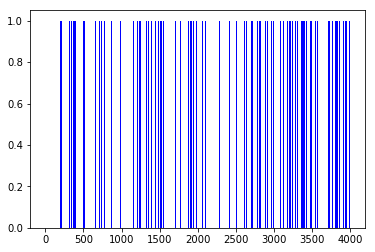

In [27]:
print('success rate: ', str(sum(rList)/num_episodes))
plt.bar(range(len(rList)), rList, color='blue')
plt.show()